In [2]:
import numpy as np
from numpy.random import random, randn
from numpy.linalg import norm
import matplotlib.pyplot as plt
from numpy import transpose as tr
import struct
from array import array
from os.path import join
%matplotlib inline

In [3]:
def read_images_labels(images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img
        
        return images, labels

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


In [4]:
# data loading:
(un_x_train, y_train) = read_images_labels('train-images.idx3-ubyte', 'train-labels.idx1-ubyte')
(un_x_test, y_test) = read_images_labels('t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte')

In [5]:
# Arrange and Normalize the images

# Convert the list to a NumPy array to make actions
un_x_train_np = np.array(un_x_train)
un_x_test_np = np.array(un_x_test)
train_images_flattened = un_x_train_np.reshape(un_x_train_np.shape[0], -1)
test_images_flattened = un_x_test_np.reshape(un_x_test_np.shape[0], -1)
x_train = (train_images_flattened / 255.0) - 0.5 
x_test = test_images_flattened / 255.0 - 0.5

C:\Users\Ofir Modei\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


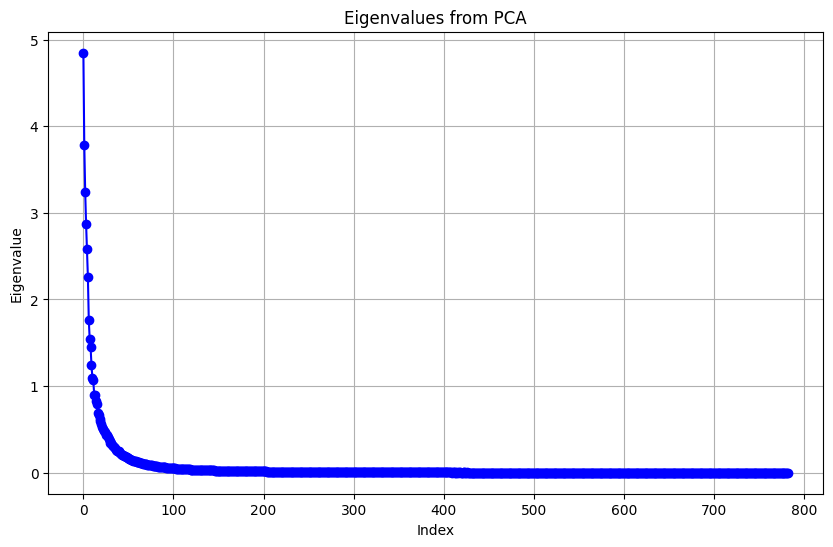

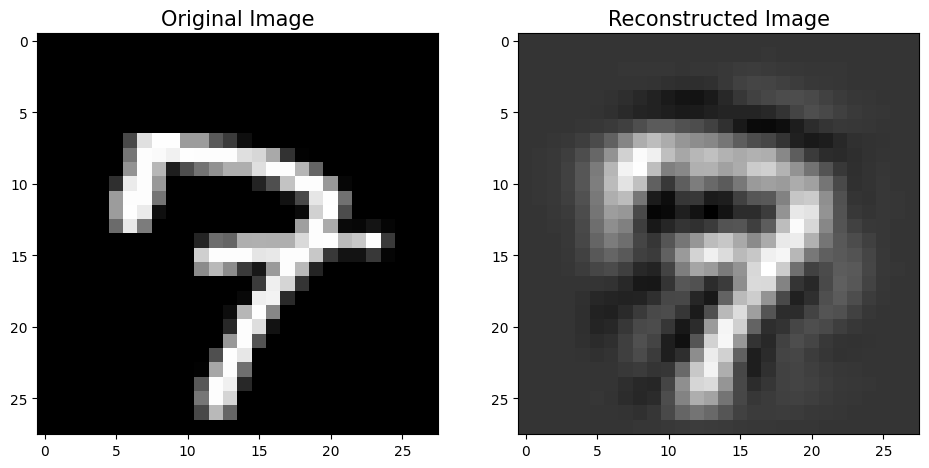

In [6]:
# PCA dimensionality reduction
m = 30000 # m is how much images we want for training
X = np.column_stack(x_train[:m])
conv = (X@(tr(X)))*(1/m)
eigenvalues, eigenvectors = np.linalg.eig(conv) 


# Plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues[1:], marker='o', linestyle='-', color='b') #ignored the first one to get nicer graph 
plt.title('Eigenvalues from PCA')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

#ignored the imagenary part for calculations
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

# Select the top 50 eigenvectors
p = 50
Up = eigenvectors[:, :p]
Z = tr(Up)@X
new_x = tr(Up @ Z)
r = np.random.randint(0, new_x.shape[0])
reconstructed = new_x[r].reshape(28,28)
show_images([un_x_train[r], reconstructed], ["Original Image", "Reconstructed Image"])

In [7]:
# Apply PCA transformation to both training and validation sets
Z_train = np.dot(Up.T, x_train[:m].T).T  # Project training data
Z_test = np.dot(Up.T, x_test.T).T         # Project test data

# Filter digits 0/1 and 8/9
def filter_digits(Z, labels, digit1, digit2):
    indices = np.where((labels == digit1) | (labels == digit2))[0]
    Z_filtered = Z[indices]
    labels_filtered = labels[indices]
    labels_filtered = (labels_filtered == digit2).astype(int)  # Convert to binary labels (0 or 1)
    return np.array(Z_filtered), np.array(labels_filtered)


# Filter digits 0/1 for binary classification
y_train = np.array(y_train)
y_test = np.array(y_test)
Z_train_01, y_train_01 = filter_digits(Z_train, y_train[:m], 0, 1)
Z_test_01, y_test_01 = filter_digits(Z_test, y_test, 0, 1)


In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def compute_cost(w, X, y, reg_param):
    m1 = X.shape[0]
    h = sigmoid(X @ w)
    
    # Clip predictions to avoid log(0) or log(1)
    epsilon = 1e-10  # Small value to avoid log(0)
    h = np.clip(h, epsilon, 1 - epsilon)
    
    # Calculate the cost
    cost = (-1/m1) * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + (reg_param / (2 * m1)) * np.dot(w, w)
    
    return cost


def compute_gradient(w, X, y, reg_param):
    m = X.shape[0]
    h = sigmoid(np.dot(X, w))
    gradient = (1/m) * np.dot(X.T, (h - y)) + (reg_param / m) * w
    return gradient

def armijo_line_search(w, X, y, gradient, direction, cost, reg_param, alpha=1.0, beta=0.5, sigma=1e-4):
    while True:
        new_w = w + alpha * direction
        new_cost = compute_cost(new_w, X, y, reg_param)
        if new_cost <= cost + sigma * alpha * np.dot(gradient, direction):
            break
        alpha *= beta
    return alpha

def gradient_descent(X, y, reg_param, num_iterations=100):
    m, n = X.shape
    w = np.zeros(n)
    cost_history = []
    gradient_norm_history = []
    
    for i in range(num_iterations):
        cost = compute_cost(w, X, y, reg_param)
        gradient = compute_gradient(w, X, y, reg_param)
        
        # Armijo line search
        direction = -gradient
        alpha = armijo_line_search(w, X, y, gradient, direction, cost, reg_param)
        
        # Update weights
        w += alpha * direction
        
        cost_history.append(cost)
        gradient_norm_history.append(np.linalg.norm(gradient))
        
        if np.linalg.norm(gradient) < 1e-3:  # Stop if gradient is small enough
            break
    
    return w, cost_history, gradient_norm_history

# Run Gradient Descent on filtered data (0/1 classification)
reg_param = 0.1
w_01, cost_history_01, grad_norm_history_01 = gradient_descent(Z_train_01, y_train_01, reg_param)

In [9]:
def compute_hessian(w, X, y, reg_param):
    m, n = X.shape
    h = sigmoid(np.dot(X, w))
    R = np.diag(h * (1 - h))
    H = (1/m) * (X.T @ R @ X) + (reg_param / m) * np.eye(n)
    return H

def exact_newton(X, y, reg_param, num_iterations=100):
    m, n = X.shape
    w = np.zeros(n)
    cost_history = []
    gradient_norm_history = []
    
    for i in range(num_iterations):
        cost = compute_cost(w, X, y, reg_param)
        gradient = compute_gradient(w, X, y, reg_param)
        hessian = compute_hessian(w, X, y, reg_param)
        
        # Update direction using Newton's method
        direction = -np.linalg.solve(hessian, gradient)
        
        # Armijo line search
        alpha = armijo_line_search(w, X, y, gradient, direction, cost, reg_param)
        
        # Update weights
        w += alpha * direction
        
        cost_history.append(cost)
        gradient_norm_history.append(np.linalg.norm(gradient))
        
        if np.linalg.norm(gradient) < 1e-3:  # Stop if gradient is small enough
            break
    
    return w, cost_history, gradient_norm_history

# Run Exact Newton method on filtered data (0/1 classification)
w_newton_01, cost_history_newton_01, grad_norm_history_newton_01 = exact_newton(Z_train_01, y_train_01, reg_param)

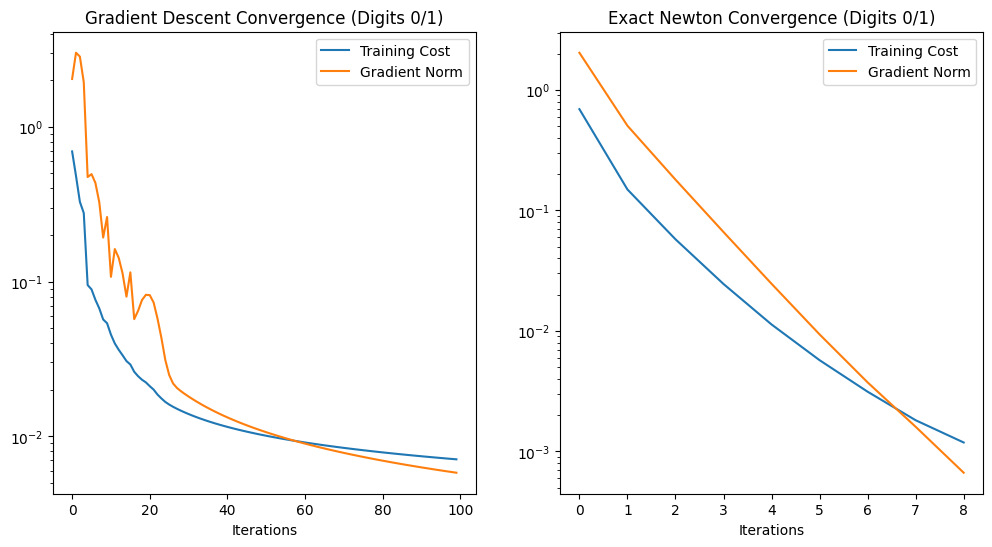

In [10]:

# Plot convergence history for Gradient Descent
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cost_history_01, label='Training Cost')
plt.plot(grad_norm_history_01, label='Gradient Norm')
plt.yscale('log')
plt.title('Gradient Descent Convergence (Digits 0/1)')
plt.xlabel('Iterations')
plt.legend()

# Plot convergence history for Exact Newton
plt.subplot(1, 2, 2)
plt.plot(cost_history_newton_01, label='Training Cost')
plt.plot(grad_norm_history_newton_01, label='Gradient Norm')
plt.yscale('log')
plt.title('Exact Newton Convergence (Digits 0/1)')
plt.xlabel('Iterations')
plt.legend()

plt.show()